In [1]:
import numpy as np
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, concatenate, Conv2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

2021-08-17 12:43:14.588267: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
data_path = "/home/samsmu/Data/Lung/CT"
working_path = data_path + "/Temp/"

### Loss

In [3]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### UNet

In [4]:
K.set_image_data_format('channels_first')
def get_unet(img_rows = 512, img_cols = 512, padding = 'same'):
    inputs = Input((1,img_rows, img_cols))
    conv1 = Conv2D(32, 3, activation='relu', padding=padding)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding=padding)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding=padding)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding=padding)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding=padding)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding=padding)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding=padding)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding=padding)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3,  activation='relu', padding=padding)(pool4)
    conv5 = Conv2D(512, 3,  activation='relu', padding=padding)(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    conv6 = Conv2D(256, 3, activation='relu', padding=padding)(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding=padding)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    conv7 = Conv2D(128, 3, activation='relu', padding=padding)(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding=padding)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    conv8 = Conv2D(64, 3, activation='relu', padding=padding)(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding=padding)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    conv9 = Conv2D(32, 3, activation='relu', padding=padding)(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding=padding)(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [55]:
def train_and_predict(working_path, use_existing):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train = np.load(working_path+"trainImages.npy").astype(np.float32)
    imgs_mask_train = np.load(working_path+"trainMasks.npy").astype(np.float32)

    imgs_test = np.load(working_path+"testImages.npy").astype(np.float32)
    imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)
    
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean  # images should already be standardized, but just in case
    imgs_train /= std

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])
    # Saving weights to unet.hdf5 at checkpoints
    model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)
    #
    # Should we load existing weights? 
    # Set argument for call to train_and_predict to true at end of script
    if use_existing:
        model.load_weights('./unet.hdf5')
        
    # 
    # The final results for this tutorial were produced using a multi-GPU
    # machine using TitanX's.
    # For a home GPU computation benchmark, on my home set up with a GTX970 
    # I was able to run 20 epochs with a training set size of 320 and 
    # batch size of 2 in about an hour. I started getting reseasonable masks 
    # after about 3 hours of training. 
    #
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, imgs_mask_train, batch_size=8, epochs=10, verbose=1, shuffle=True,
              callbacks=[model_checkpoint])

    # loading best weights from training session
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('./unet.hdf5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    num_test = len(imgs_test)
    imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0)[0]
    np.save('masksTestPredicted.npy', imgs_mask_test)
    mean = 0.0
    for i in range(num_test):
        mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])
    mean/=num_test
    print("Mean Dice Coeff : ",mean)
    

def train(working_path, use_existing):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train = np.load(working_path+"trainImages.npy").astype(np.float32)
    imgs_mask_train = np.load(working_path+"trainMasks.npy").astype(np.float32)
    
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

#    imgs_train -= mean  # images should already be standardized, but just in case
    imgs_train /= imgs_train.max()
    imgs_mask_train /= imgs_mask_train.max()
    
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])
    # Saving weights to unet.hdf5 at checkpoints
    model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)
    #
    # Should we load existing weights? 
    # Set argument for call to train_and_predict to true at end of script
    if use_existing:
        model.load_weights('./unet.hdf5')
        
    # 
    # The final results for this tutorial were produced using a multi-GPU
    # machine using TitanX's.
    # For a home GPU computation benchmark, on my home set up with a GTX970 
    # I was able to run 20 epochs with a training set size of 320 and 
    # batch size of 2 in about an hour. I started getting reseasonable masks 
    # after about 3 hours of training. 
    #
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, imgs_mask_train, batch_size=8, epochs=40, verbose=1, shuffle=True,
              callbacks=[model_checkpoint])


In [72]:
#train_and_predict(working_path, False)
train(working_path, True)

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Epoch 1/40
126/126 [==============================] - 35s 269ms/step - loss: -0.5965 - dice_coef: 0.5965
Epoch 2/40
126/126 [==============================] - 34s 272ms/step - loss: -0.5841 - dice_coef: 0.5841
Epoch 3/40
126/126 [==============================] - 34s 274ms/step - loss: -0.5960 - dice_coef: 0.5960
Epoch 4/40
126/126 [==============================] - 35s 275ms/step - loss: -0.6196 - dice_coef: 0.6196
Epoch 5/40
126/126 [==============================] - 35s 276ms/step - loss: -0.6285 - dice_coef: 0.6285
Epoch 6/40
126/126 [==============================] - 35s 276ms/step - loss: -0.5487 - dice_coef: 0.5487
Epoch 7/40
126/126 [==============================] - 35s 277ms/step - loss: -0.5480 - dice_coe

In [73]:
m = get_unet()
m.load_weights('./unet.hdf5')
imgs_test = np.load(working_path+"testImages.npy").astype(np.float32)
imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)

imgs_test /= imgs_test.max()

# loading best weights from training session
print('-'*30)
print('Loading saved weights...')
print('-'*30)


print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
num_test = len(imgs_test)
imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
for i in range(num_test):
    imgs_mask_test[i] = m.predict([imgs_test[i:i+1]], verbose=0)[0]
np.save('masksTestPredicted.npy', imgs_mask_test)
mean = 0.0
for i in range(num_test):
    mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])
mean/=num_test
print("Mean Dice Coeff : ",mean)    


------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
Mean Dice Coeff :  0.16535642815670173


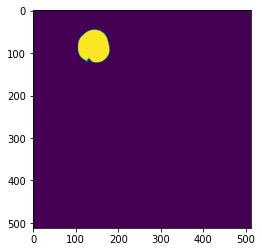

In [80]:
xx = np.load("masksTestPredicted.npy").astype(np.float32)
plt.imshow(xx[6,0])

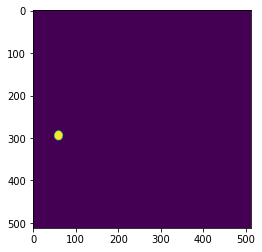

In [23]:
plt.imshow(imgs_mask_test_true[0,0])

In [28]:
imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)

In [38]:
imgs_mask_train = np.load(working_path+"trainMasks.npy").astype(np.float32)

0.003921569

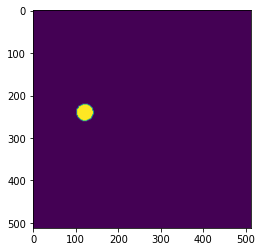

In [20]:
plt.imshow(imgs_mask_train[8,0])

In [59]:
imgs_mask_test  = np.load("masksTestPredicted.npy").astype(np.float32)


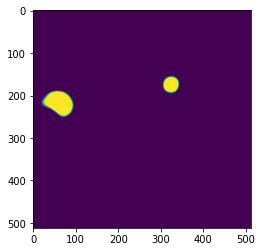

In [71]:
plt.imshow(imgs_mask_test[10][0])


image 0


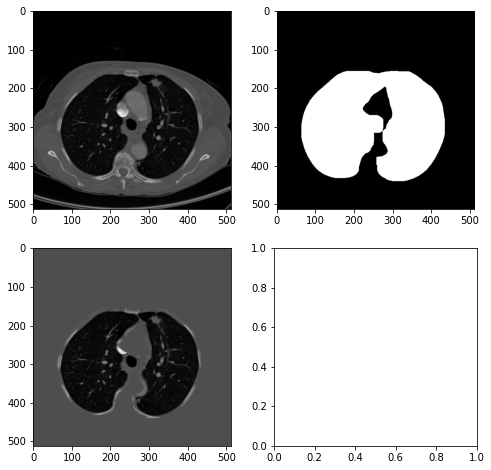

image 1


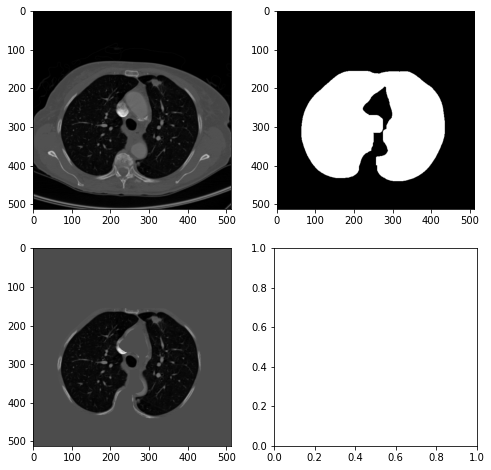

image 2


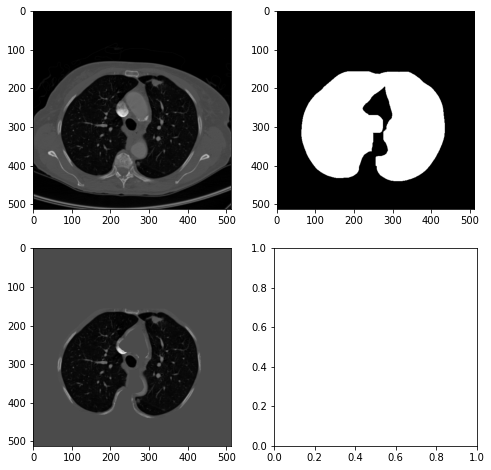

In [26]:
imgs = np.load(working_path+'images_0000_0454.npy')
lungmask = np.load(working_path+'lungmask_0000_0454.npy')

for i in range(len(imgs)):
    print ("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(lungmask[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*lungmask[i],cmap='gray')
    plt.show()

In [8]:
train_and_predict(working_path, False)

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------


2021-08-10 08:52:18.657762: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-10 08:52:18.678001: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3498045000 Hz


Epoch 1/20


2021-08-10 08:52:19.472131: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-08-10 08:52:20.302753: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-08-10 08:52:20.376323: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-08-10 08:52:21.180887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


135/135 [==============================] - 74s 304ms/step - loss: -3.9842e-05 - dice_coef: 3.9841e-05
Epoch 2/20
135/135 [==============================] - 9s 67ms/step - loss: -3.5880e-05 - dice_coef: 3.5879e-05
Epoch 3/20
135/135 [==============================] - 9s 67ms/step - loss: -3.9819e-05 - dice_coef: 3.9819e-05
Epoch 4/20
135/135 [==============================] - 9s 67ms/step - loss: -3.8279e-05 - dice_coef: 3.8281e-05
Epoch 5/20
135/135 [==============================] - 9s 67ms/step - loss: -3.9436e-05 - dice_coef: 3.9436e-05
Epoch 6/20
135/135 [==============================] - 9s 67ms/step - loss: -3.8215e-05 - dice_coef: 3.8222e-05
Epoch 7/20
135/135 [==============================] - 9s 68ms/step - loss: -4.8771e-05 - dice_coef: 4.8771e-05
Epoch 8/20
135/135 [==============================] - 9s 68ms/step - loss: -6.5089e-05 - dice_coef: 6.5087e-05
Epoch 9/20
135/135 [==============================] - 9s 68ms/step - loss: -8.8471e-05 - dice_coef: 8.8470e-05
Epoch 10/2

image 0


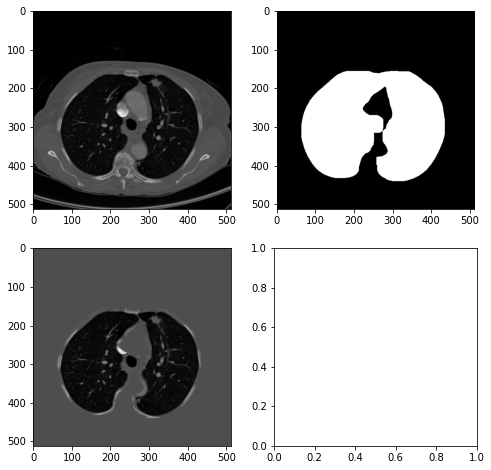

image 1


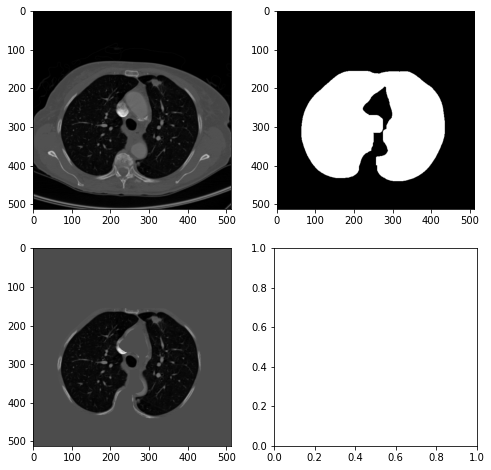

image 2


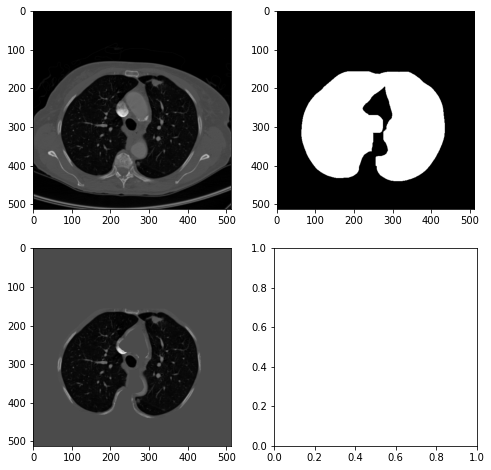

In [84]:
imgs = np.load(working_path+'images_0000_0454.npy')
lungmask = np.load(working_path+'lungmask_0000_0454.npy')

for i in range(len(imgs)):
    print ("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(lungmask[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*lungmask[i],cmap='gray')
    plt.show()